## Batch reactors

Goal of this script is to understand how batch reactors are applied in Skimpy, how they are applied in normal BB kinetic models, and perhaps how to rewrite our model for a use-case in BB kinetics.

In [1]:
from pytfa.io.json import load_json_model

import numpy as np
import pandas as pd
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot

from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *

In [8]:
reactor = make_batch_reactor('../models/single_species.yaml')
reactor.compile_ode(add_dilution=False)

path_to_kmodel = '../models/shiki_pathway_testmodel.yml'
path_to_tmodel = '../models/shiki_pathway_testmodel_thermodynamic.json'
path_to_sample='../data/sample06092022.csv'
# load models
tmodel = load_json_model(path_to_tmodel)
kmodel = load_yaml_model(path_to_kmodel)


reference_solutions = pd.read_csv(path_to_sample, index_col=0)
ref_concentrations = load_concentrations(reference_solutions.loc['strain_1'], tmodel, kmodel,
                                                      concentration_scaling=reactor.concentration_scaling)


print(reference_solutions['LC_biomass_e'])
print(ref_concentrations['biomass_e'])
reactor.initial_conditions['biomass_strain_1'] = 0.1e12 # Number of cells
reactor.initialize(ref_concentrations, 'strain_1')
sol = reactor.solve_ode(np.linspace(0, 10.0, 1000),
                            solver_type='cvode',
                            rtol=1e-9,
                            atol=1e-9,
                            max_steps=1e9,
                            )



2023-05-22 11:16:58,940 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies
2023-05-22 11:17:37,384 - thermomodel_redGEMv1_MergedLMPDsAndBiomass - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2023-05-22 11:17:37,994 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies


strain_1   -4.60517
Name: LC_biomass_e, dtype: float64
10000.000000000015


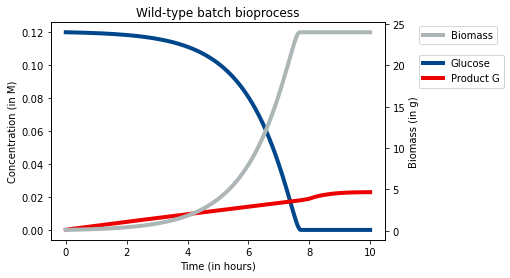

In [9]:


import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()


#fig.savefig("concentrations.svg")
ax2 = ax1.twinx()
ax1.plot(sol.time,sol.concentrations['glc_D_e']/reactor.concentration_scaling,color="#00468BFF",linewidth=4,label="Glucose")
ax1.plot(sol.time,sol.concentrations['strain_1_G_c']/reactor.concentration_scaling,color="#ED0000FF",linewidth=4,label="Product G")
ax1.set_xlabel("Time (in hours)")

MASS_PER_CELL = 1e-12 #[g/cell]
species = ['biomass_strain_1', ]
ax2.plot(sol.time, sol.concentrations[species].values*MASS_PER_CELL,color="#ADB6B6FF",linewidth=4,label="Biomass")
ax1.set_ylabel("Concentration (in M)")
ax2.set_ylabel('Biomass (in g)')
plt.title("Wild-type batch bioprocess")
ax1.legend(loc=(1.1, 0.7))
ax2.legend(loc=(1.1, 0.9))
plt.show()
#fig.savefig("../../../Results/Benchmark paper/Figure 1/biomass.svg", bbox_inches="tight")


In [128]:
from skimpy.analysis.ode.utils import make_flux_fun
fluxes_strain_1 = make_flux_fun(reactor.models.strain_1, QSSA)

fluxes = []
model_params = reactor.models.strain_1.parameters
parameters = {str(p.symbol):p.value for p in model_params.values() if not p.value is None}
for i, concentrations in sol.concentrations.iterrows():
    this_fluxes = fluxes_strain_1(concentrations, parameters=parameters)
    fluxes.append(this_fluxes)
# Make it a DataFrame
fluxes = pd.DataFrame(fluxes)/reactor.flux_scaling
fluxes.index = sol.time

2.012012    10.435680
2.027027    10.435640
2.042042    10.435600
2.057057    10.435561
2.072072    10.435523
              ...    
2.927928    10.434483
2.942943    10.434484
2.957958    10.434486
2.972973    10.434488
2.987988    10.434492
Name: GLCptspp, Length: 66, dtype: float64

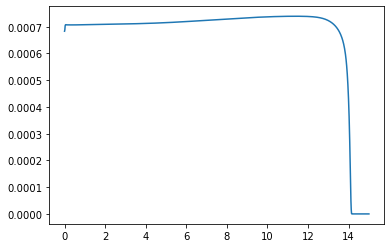

In [129]:
plt.plot(sol.time,fluxes['LMPD_biomass_c_17_462'])
fluxes['GLCptspp'][2:3]

In [139]:
fluxGLC=np.mean(fluxes['GLCptspp'][2:5])
fluxBiomass=np.mean(fluxes['LMPD_biomass_c_17_462'][2:4])
fluxProduct=np.mean(fluxes['Enzyme_G'][2:4])

a=fluxGLC/fluxBiomass
b=fluxGLC/fluxProduct
b

1549.627648319189

In [187]:
#Parameters
qsmax=-0.3*1e6 #CmolS.Cmolx-1.h_1
Ks=0.01*180*1e6 #Cmol.S.L-1
a= -14.687 #S requirement for biomass
b=-1.549
ms=-0.01 #CmolS.Cmolx-1.h-1


#Initial conditions
Cs=3 #Cmol.L-1
Cx=0.01 #Cmol.L-1
Vl=1

def Batch(t,y,qsmax,Ks,a,ms):
    Cs,Cx=y
    if Cs<0:
        Cs=0
    #Kinetic equations
    qs=qsmax*(Cs/(Ks+Cs))
    qx=(qs-ms)/a
    #Rate equations
    Rs=qs*Cx*1
    Rx=qx*Cx*1
    #Rc=-(Rs+Rx)  #Rco2 and Ro2
    R=[Rs,Rx]
    return R

def qrate(sol,t,tend,ms):
    dt=tend/len(sol)
    Cs=sol
    qs=qsmax*(Cs/(Ks+Cs))
    qx=(qs-ms)/a
    return qs,qx

def rates(sol,t,tend):
    dt=tend/np.shape(sol)[0]
    S=sol[1:np.shape(sol)[0],0]-sol[0:np.shape(sol)[0]-1,0]
    X=sol[1:np.shape(sol)[0],1]-sol[0:np.shape(sol)[0]-1,1]
    
    #substrate rate and biomass Rate
    Rs=np.divide(S,dt)
    Rx=np.divide(X,dt)
    #Oxygen rate and CO2 rate, and respiratory quotient
    Rc=-(Rs+Rx)
    Ro=(4*Rs+4.2*Rx)/4
    Rq=Rc/-Ro

    t=t[1:len(t)]

    return t,Rs,Rx,Rc,Ro,Rq




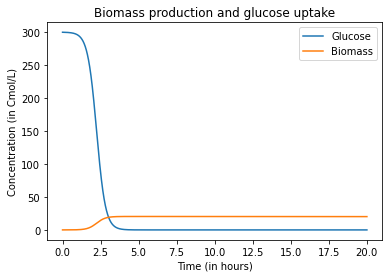

In [188]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


sol = solve_ivp(Batch, [0, 20], [300, 0.01], args=(qsmax,Ks,a,ms),
                dense_output=True)
    
t = np.linspace(0, 20,100000)
z = sol.sol(t)
z=z.T

#print(np.shape(z))
t1,Rs,Rx,Rc,Ro,Rq=rates(z,t,50)
qst,qxt=qrate(z[:,0],t,50,ms)



# Batch Plots
plt.plot(t,z[:,0],label="Glucose")
plt.plot(t,z[:,1],label="Biomass")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentration (in Cmol/L)")
plt.title("Biomass production and glucose uptake")          
plt.legend()
plt.show()


In [186]:
#biomassa
15.9994*0.5+(12.0107)+(14.0007*0.2)+(1.00794*1.8)

#glucose feed (25 g/l)
25/180.156

0.13876862274917293

In [194]:
from skimpy.utils.general import get_stoichiometry
S = get_stoichiometry(kmodel, kmodel.reactants).todense()
print(np.shape(S))

(55, 72)


In [210]:
len(kmodel.reactants)
kmodel.parameters.glc_D_e.value

67200.0

In [212]:
67200/36000


1.8666666666666667